# Introduction to Bayesian Modeling for Sediment Remediation Projects

## Abstract
*Bayesian statistical methods are well-established and commonly used in many fields, however, some fields are slower to adopt Bayesian methods than others.  The highly regulated environmental remediation industry has been slow to adopt Bayesian methods in part due to lack of guidance and examples within the industry.  However, Bayesian methods offer a number of potential improvements over currently used techniques, such as the following:* 

1. Coherent estimation of uncertainties.
2. Intuitive and flexible framework to meet problem-specific needs.   
3. Transparent way to imbed scientific knowledge within analyses.
4. Maximize the information that can be gained from limited and censored data. 

*This paper provides a high level introduction to Bayesian methods for sediment remediation and presents several example models using well-established Bayesian techniques.  Worked examples in this paper include:*
1. Bayesian non-detect treatment
2. Bayesian treatment of analytical models (the SEDCAM natural recovery model and Lead210 geochronological model), and 
3. Heirarchical stormwater estimation model.

## Introduction
Improvements in computation and statistical methods have resulted in the recent florishing of Bayesian methods across the sciences [citation].  Although Bayesian statistical methods are now well established and commonly used in many fields, some fields are slower to adopt Bayesian methods for historical reasons [citation].  The highly regulated environmental remediation industry has been slow to adopt Bayesian methods in part due to lack of examples and guidance within the industry.  This paper provides a high level introduction to Bayesian methods for sediment remediation and presents several example models.

## Bayesian Statistics from a Modeling Perspective
This section provides a high level description of Bayesian statistics from a physical modeling perspective.  At it's core, Bayes' rule allows the researcher to estimate unmeasured parameters from measured data, leveraging the fact that the probability is the model, given the data is proportional to the probability of the data given the model.   

$$
Pr(\theta | y) \propto {Pr(y | \theta) Pr(\theta)}
$$

$Pr(\theta | y)$ is the probability of the model parameters $\theta$ given the observed data $y$.  $Pr(y | \theta)$ is the probability of the data $y$ given the unmeasured parameters $\theta$ (the likelihood), and $Pr(\theta)$ is the probability of the unmeasured parameters (the prior).  



From a modeling perspective, consider a generative model with $\theta$ as inputs and $y$ as outputs.   
$$\theta \to Model \to y$$
Bayesian inference is a way to infer the probability of $\theta$ given the data $y$ and the model.  It is relatively simple to adapt any analytical (i.e., equation-based) model for a Bayesian inference engine.  The Bayesian inference engine also requires the specification of prior probability distributions on $\theta$, and the specification of a likelihood function for $y$ to perform inference, as will be demonstrated in the examples.  

## Bayesian Non-detect Estimation

### Background
Left-censored data are common in environmental chemistry and occur when concentrations are at or below the lower limits of laboratory equipment sensitivity.  Laboratories report statistically-derived detection limits, and samples that are not detected are reported as being below those detection limits (i.e., <DL).  For the purpose of this paper, a non-detect concentration is any left-censored value with a specified laboratory limit referred to as teh DL; a discussion of various laboratory limits (e.g., method detection limits, report limits, EMPCs) is beyond the scope of this paper.    

Numerous articles, software and books have been developed for interpreting non-detect concentrations, for example:
* EPA, 2014.  https://www.epa.gov/sites/default/files/2016-05/documents/tech_notes_10_jun2014_r.pdf, 
* Helsel ([..several citations]). 
* [ProUCL guidance]

Common techniques for non-detect estimation include substitution (e.g., DL/2 or DL/$\sqrt{2}$), Kaplan-Meier estimation (KM), regression on order statistics (ROS), maximum likelihood estimation (MLE), and multiple imputation (MI).  These techniques have been compared in a number of simulation studies (e.g., Canales et. al., 2018, Antweiler and Taylor, 2018) and are often used to produce point estimates for non-detected values that can be used in subsequent analyses.  

The Bayesian approach is different due to the focus on probability distributions.  Because Bayesian analysis can handle probability distribution data as fluidly as point estimate data, there is no need to produce point-value estimates for non-detect concentrations.  Instead, non-detects can remain as probability distributions between zero and the detection limit.  A statistical description of a non-detect probability distribution (e.g., mean, median, mode) can be provided if point estimates are required.  The Bayesian approach to non-detect treatment was compared to other standard techniques in Suzuki et.al. 2020, with the finding that Bayesian inference (referred to as "Markov Chain Monte Carlo Method" in the paper) provided improved estimates compared to traditional approaches.  

Treating non-detects as probability distributions can simplify the data analysis workflow within the Bayesian framework because non-detect imputation is not required to be a separate step in the analysis. The following section walks through Bayesian non-detect treatment for nitrite stormwater data for the Esquimalt Harbour Nutrient Loading Study.

### Data Summary

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
# supporting functions
import functions as funcs
import importlib
importlib.reload(funcs)

<module 'functions' from 'c:\\Users\\gbrunkhorst\\Documents\\AQBayes\\functions.py'>

# Upload and Wrangle Data

In [3]:
df, analytes, dict_maps = funcs.read_wrangle_data()
df.columns
season_map, analytes_map, outfalls_map, area_map = dict_maps
# select analyte
analyte = 'Nitrite'
data = df.loc[df.Analyte==analyte,:].copy()
data.columns
data.shape
category1_idx = 'Season_idx'
category2_idx = 'Area_idx'
# need to reindex categories of interest because of potential
# missing data with this analyte
data, cat1_map = funcs.analyte_df(df, analyte, category1_idx)
data, cat2_map = funcs.analyte_df(data, analyte, category2_idx)
data.head()

,Unnamed: 0,sys_loc_code,sys_sample_code,Analyte,Date,Value,Detect_Y_N,Outfall,Area,HarborDischarge,Day_of_year,Month,Season,Season_idx,Detect,Analyte_idx,Outfall_idx,Area_idx
7,7,OUTFALL E,61956-20070117,Nitrite,2007-01-17,0.0028,Y,862A,Graving Dock,1,17,1,1-W,0,True,3,36,4
9,9,OUTFALL C,61969-20070118,Nitrite,2007-01-18,0.0021,Y,863,Graving Dock,1,18,1,1-W,0,True,3,38,4
17,23,CFSA-SW,CFSA-SW-080513,Nitrite,2008-05-13,0.0260,Y,864A,Monroe Head,1,134,5,2-Sp,1,True,3,40,6
30,36,COL-SW-911,COL-SW-911-091216,Nitrite,2009-12-16,0.0090,Y,911,Colwood,1,350,12,4-F,3,True,3,64,2
37,56,DY-SW-832A,DY-SW-832A-120124,Nitrite,2012-01-24,0.0180,Y,832A,A/B Jetty,1,24,1,1-W,0,True,3,3,0


**Table 1 Summary Statistics for Nitrite**

In [4]:

# Summarize
summary = data[data.Analyte==analyte].groupby(
        by=['Analyte']).agg(['count','mean','std','median', funcs.percentile(95), 'max']).Value.merge(
    data.groupby(by=['Analyte']).agg('mean').Detect*100, 
        left_index=True, right_index=True)
summary

C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\pandas\core\groupby\generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


,count,mean,std,median,percentile_95,max,Detect
Analyte,,,,,,,
Nitrite,144,0.013995,0.030503,0.005,0.05985,0.238,53.472222


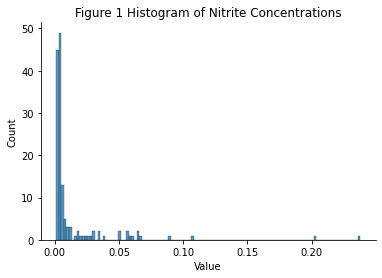

In [5]:
data = df[df.Analyte==analyte]
sns.histplot(data = data, x = 'Value')
plt.title('Figure 1 Histogram of Nitrite Concentrations')
sns.despine()

Table 1 and Figure 1 show the characteristics of the nitrite dataset, which is highly skewed with many low values near zero and occasional higher values.  57% percentage of the values were not detected (left-censored).  Non-detect samples are summarized based on the DL.

Figure 2 differentiates the detected values and the non-detect values with the non-detects plotted at the DL.  As expected, the non-detects are near zero, however, due to different detection limits in different years, there are some non-detect samples at relatively high DLs.   

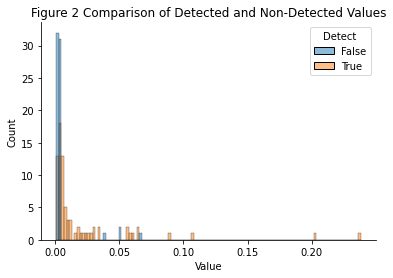

In [6]:
sns.histplot(data = data, x = 'Value', hue  = 'Detect')
plt.title('Figure 2 Comparison of Detected and Non-Detected Values')
sns.despine()

Table 2 lists the DLs in the dataset and the count for each.  These will be used in the model.  

In [7]:
dls_df = pd.DataFrame(
    df[(df.Analyte==analyte)&(df.Detect==False)].groupby(by='Value').count().iloc[:,0])
dls_df = dls_df.reset_index()
dls_df.columns = ['DLs','Count']
shapes = dls_df.Count.tolist()
dls = dls_df.DLs.tolist()
# required for numerical stability
lower = .00001
dls_df

,DLs,Count
0,0.001,1
1,0.002,31
2,0.005,31
3,0.039,1
4,0.050,2
5,0.067,1


### Univariate Gamma Model Description

The general method for fitting a univariate distribution under to the Bayesian framework is to: 
1. Select a parametric distribution (or mixture of distributions) to fit the data (i.e., a likelihood function)
2. Select prior distributions for the parameters of the selected distribution (e.g., mu and sigma for a normal distribution)
3. Perform Bayesian inference on the observed data to calculate the posterior distributions for the distribution parameters.  

#### Gamma Distribution
Gamma and lognormal distributions are commonly used to fit environmental data, which tends to be positive-only right-tail-skewed.  The gamma distribution is selected for this analysis, primarily because the lognormal distribution can result in predictions that are biased high due of the thickness of the tail.  The gamma distribution can fit skewed data without having as fat a tail as the lognormal distribution.  The gamma distribution also has the advantage of being in standard units (rather than lognormalized units) and mimicking near-zero-inflated distribution that can be seen in Figure 1.  

 Figure 2 presents the best-fit of the gamma distribution 

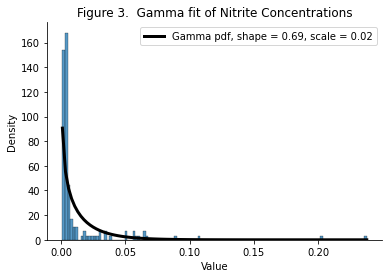

In [8]:
shape, loc, scale = st.gamma.fit(data.Value, floc=0)
fig, ax = plt.subplots()
x = np.linspace(data.Value.min(), data.Value.max(), 100)
ax.plot(x, st.gamma.pdf(x,  a = shape, scale = scale),
       'black', lw=3,  label=
       f'Gamma pdf, shape = {round(shape,2)}, scale = {round(scale, 2)}')
sns.histplot(data = data, x = 'Value', stat='density')
plt.title('Figure 3.  Gamma fit of Nitrite Concentrations')
sns.despine()
plt.legend()

The gamma distribution is described by two parameters and has a number of different parameterizations.  Following provides the relationships between shape (or alpha), scale, rate (or beta), mu (mean), sigma (standard deviation), and CV (the coefficent of variation) and contains redundancy for clarity:  

shape = alpha  
rate = beta  
scale = 1/ rate = 1/ beta  
mu = alpha/ beta  
sigma = $\sqrt{alpha}$/ beta  
alpha = mu^2/ sigma^2  
beta = mu/ sigma^2  
CV = sigma/ mu  
alpha = 1/CV^2  

As an error model for a gamma general linearized model, the gamma distribution is typically parameterized with a constant alpha, which results in heteroskidastic data, or a constant CV for the regression, consistent with the characterization of many environmental datasets (i.e., standard deviation is smaller in proportion to expected concentration).   

For the above curve fit the following parameters are calculated:   

In [13]:
alpha = shape
beta = 1/scale
mu = alpha/ beta
sigma = alpha**(1/2)/ beta
CV = sigma/mu
print(f'alpha={round(alpha,2)}, beta={round(beta)}, mu={round(mu,3)}, sigma={round(sigma,3)}, CV={round(CV,1)}')

alpha=0.69, beta=49, mu=0.014, sigma=0.017, CV=1.2


This fit gives the near-zero-inflated curve of the gamma distribution due to an alpha less than one.  For the purpose of this study, the gamma distribution is reasonably good fit and provides a good framework for estimating concentrations.  

[TODO] how to select a likelihood function.  

#### Select Prior Distributions

We will parameterize the gamma distribution in terms of mu and CV to be consistent with parameters that are commonly summarized in environmental data.  We will use the summary statistics in step one to develop weakly informative consistent with common practice in the Bayesian setting.  The gamma parameters are themselves parameterized as normal distributions bounded to be positive, with a standard deviation equal to the mean.     

In [14]:
mu_prior_mu = mu
mu_prior_sd = mu
cv_prior_mu = CV
cv_prior_sd = CV

#### Perform Bayesian Inference
We will use pymc3 to calculate a posterior distribution given the data.    

In [15]:
import pymc3 as pm
import arviz as az

In [16]:
# Pymc3 non-detect model wrapped in a function
def nd_model(data, mu_prior_mu, mu_prior_sd, cv_prior_mu, cv_prior_sd, dls, shapes):
    with pm.Model() as model:

        obs_detected = pm.Data('obs_detected', data)
        # distribution parameters
        lower = 1e-6
        mu = pm.TruncatedNormal("mu", mu = mu_prior_mu, sigma =  mu_prior_sd, lower = lower)
        cv = pm.TruncatedNormal("cv", mu =  cv_prior_mu, sigma =  cv_prior_sd, lower = lower)

        # add a bounded gamma for each observed non-detect
        for i in range(len(dls)):
            BoundedGamma = pm.Bound(pm.Gamma, lower = lower, upper=dls[i])
            BoundedGamma("left_censored_"+str(i), mu=mu, sigma=cv*mu, shape=shapes[i])

        # observed data
        predicted = pm.Gamma("predicted", mu=mu, sigma=cv*mu, observed= obs_detected)
    return model

In [17]:
model = nd_model(data.Value.values,  mu_prior_mu, mu_prior_sd, cv_prior_mu, cv_prior_sd, dls, shapes)


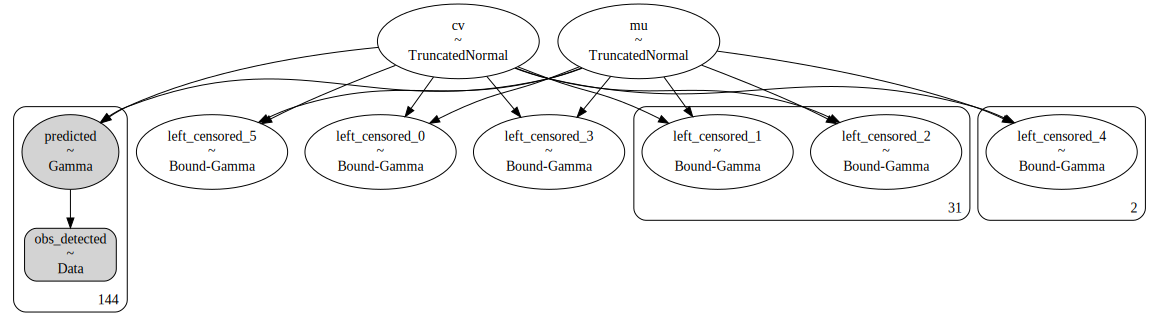

In [18]:
pm.model_to_graphviz(model)


In [19]:
with model:
    posterior = pm.sample()
    idata = az.from_pymc3(trace = posterior)
# az.summary(idata, hdi_prob=0.9, stat_funcs = {"median": np.median}, extend= True )

C:\Users\GBRUNK~1\AppData\Local\Temp/ipykernel_20376/2473704863.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  posterior = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [left_censored_5, left_censored_4, left_censored_3, left_censored_2, left_censored_1, left_censored_0, cv, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


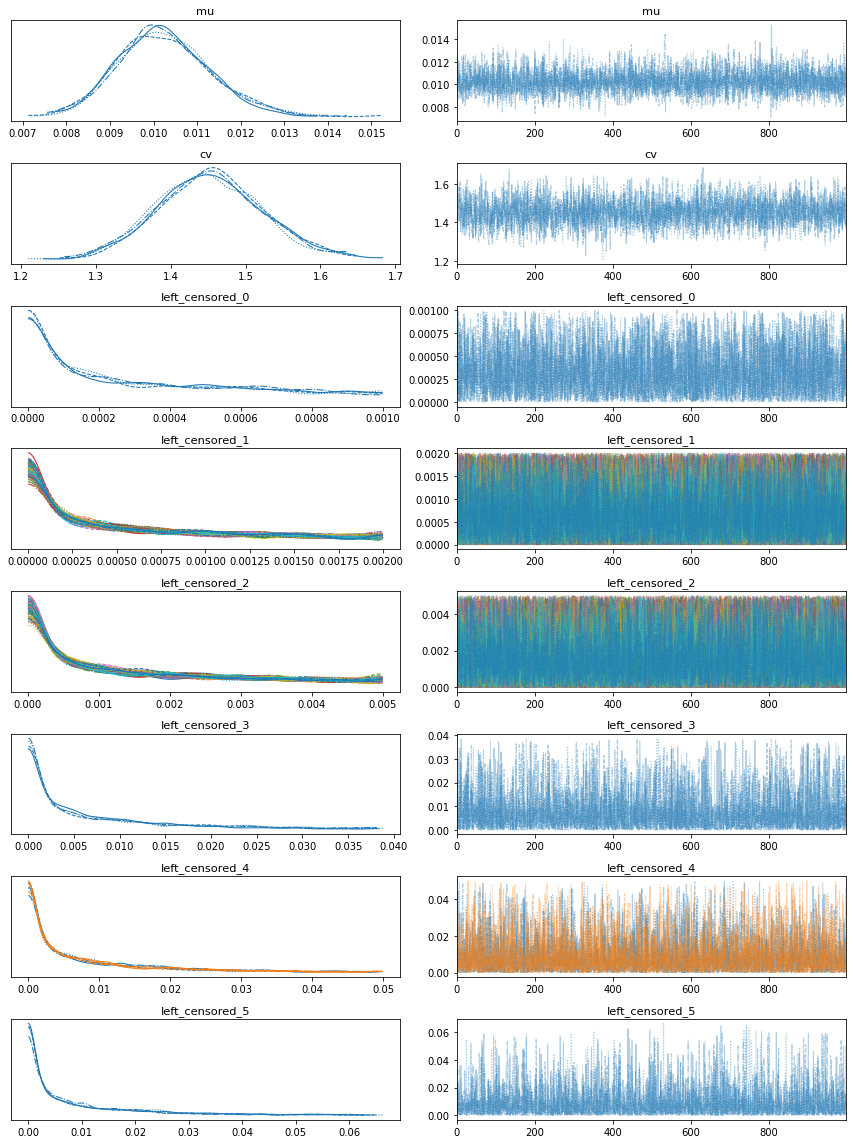

In [20]:
az.plot_trace(idata)
plt.tight_layout()

The MCMC trace looks good.  

### Results

No handles with labels found to put in legend.


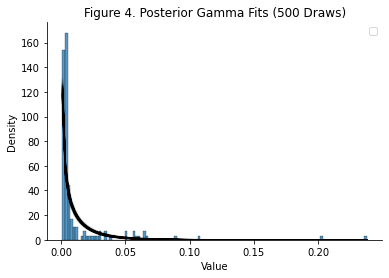

In [21]:
idxs = np.arange((posterior['mu'].shape[0]))
n = 500
idxs = np.random.choice(idxs, n, replace=False)

shape, loc, scale = st.gamma.fit(data.Value, floc=0)
fig, ax = plt.subplots()
x = np.linspace(data.Value.min(), data.Value.max(), 100)
for idx in idxs:
       mu = posterior['mu'][idx]
       cv = posterior['cv'][idx]
       sd = cv * mu
       alpha = mu**2/sd**2
       beta = mu/sd**2
       ax.plot(x, st.gamma.pdf(x,  a = alpha, scale = 1/beta),
              'black', alpha = .01)
sns.histplot(data = data, x = 'Value', stat='density')
plt.title('Figure 4. Posterior Gamma Fits (500 Draws)')
sns.despine()
plt.legend()

Figure 4 shows 500 draws from the MCMC gamma fit to the data.  The figure shows a tight range of estimates across MCMC draws. 

In [22]:
censored_list

NameError: name 'censored_list' is not defined

In [ ]:
censored = censored_list[0]
for censored in censored_list:
    print(censored, posterior[censored][:,0].shape)

left_censored_0 (4000,)
left_censored_1 (4000,)
left_censored_2 (4000,)
left_censored_3 (4000,)
left_censored_4 (4000,)
left_censored_5 (4000,)


In [ ]:
posterior[censored][:,0]

array([1.12518644e-02, 3.45751645e-02, 9.01967479e-05, ...,
       2.43260996e-02, 8.74316942e-04, 1.10817712e-02])

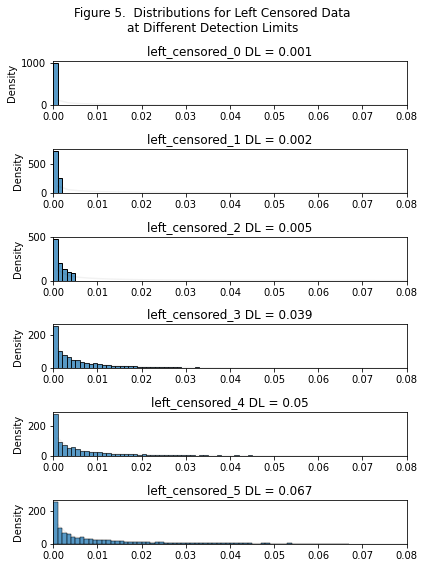

In [ ]:
censored_list = ["left_censored_"+str(i) for i in range(len(dls))]
fig, axes = plt.subplots(6,1, figsize=(6,8))
#x = np.linspace(data.Value.min(), data.Value.max(), 100)
for dl, censored, ax in zip(dls, censored_list, axes):
    plot_data = posterior[censored][:,0]
    sns.histplot(plot_data, stat='density', ax=ax, binwidth=.001)
    mu = posterior['mu'].mean()
    cv = posterior['cv'].mean()
    sd = cv * mu
    alpha = mu**2/sd**2
    beta = mu/sd**2
    ax.plot(x, st.gamma.pdf(x,  a = alpha, scale = 1/beta),
            'black', alpha = .05)
    #ax.set_ylim(0,100)
    ax.set_xlim(0,.08)
    #ax.get_legend().remove()
    ax.set_title(censored+' DL = '+str(round(dl,3)))
plt.suptitle('Figure 5.  Distributions for Left Censored Data\nat Different Detection Limits')
plt.tight_layout()


Figure 5 presents the probability distributions for the left censored data at the different detection limits.  Each non-detect value follows the distribution shape for the dataset truncated at the detection limit.  Higher detection limit samples take on the shape of the overall distribution and lower detection limit samples are closer to zero.  Note that non-detects will impact the Bayesian inference in proportion to the information they provide.  Higher detection limit samples will hardly affect the overall mean and coefficient of variation, and lower detection limit samples will bring the overall mean and coefficient of variation downward.  

### Comparison to Other Methodologies
A full comparison to other approaches to non-detect estimation is beyond the scope of this paper.  However, methodologically, the Bayesian approach has many similarities to other approaches.  Similar to MLE, ROS, and MI, a distribution is used to estimate values of the the non-detected values.  Like MLE, the likelihood is a key component of the calculation.  the major differences are that a probability distribution for each non-detect is the output of the analysis, and the probability distribution used as the basis for the analysis is "fuzzy" - in this case a draw of 4000 gamma distributions.    

### Conclusions


## Model Description
### Model Components
The purpose of the model is to provide reasonable estimates of stormwater nutrient concentrations by area and by season.  The components of the model are the following:  
1. **Gamma Error Term**: the data are assumed to be gamma-distributed around the mean values.  The mean is determined based on the regression, and the standard deviation is assumed to be proportional to the mean.  The coeffiecient of variation, which is the ratio between the standard deviation and the mean, is a model parameter  The gamma distribution is a reasonable choice to skewed, positive-only data we see in the dataset.   
2. **Non-detect Imputation**: each non-detect value is added to the model as a probability distribution between zero and its detection limit in the shape of the gamma error term.
3. **General Linearized Model**: the core of the model is a linear regression model with an intercept term and multiple regression across two categories (area and season).  A link function ensures that the linear model returns positive-only values to the gamma error term.  
4. **Hierachical Structure**: the regression parameters have adaptive priors which help to shrink data toward a common mean, which helps to improve estimates for categories with low sample counts.

Putting the components together, the model can be referred to as a Hierachical Gamma General Linearized Model with Non-Detect Imputation. The hierarchical structure is similar to the canonical analysis of radon levels in Gelman et.al., 2016. 

The first two components are are discussed in the next section (Bayesian Non-Detect Estimation), and the complete model is discussed in the subsequent section (Multiple Regression). 

## Multiple Regression

### Background
The previous section presented a univariate gamma model and showed how it can incorporate non-detected values.  This section combines the univariate gamma model with multiple regression for the complete model.  

### Data Transformations

In [1]:
# set mean to 5 for regression
set_mean_const = 5
transformer = funcs.transformer_shift_mean(data = data.Value_ND_Est,
                                        set_mean_const = set_mean_const)
data['Value_transformed'] = transformer.transform()
data['Value_transformed'].mean(), data.Value.mean()

NameError: name 'funcs' is not defined

Set priors 

In [ ]:
mu_prior = 5
CV_prior = 1.5

### Multivariate Model Description

In [ ]:
def gamma_GLM(data, category1_idx_name, category2_idx_name):
    with pm.Model() as model:
        # Data - transformed
        obs_conc_trans = pm.Data('obs_conc_trans', data.Value_transformed.values)

        # Category indexes
        category1_idx = pm.Data('category1_idx', data[category1_idx_name].values)
        category1_no = len(data[category1_idx_name].unique())
        category2_idx = pm.Data('category2_idx', data[category2_idx_name].values)
        category2_no = len(data[category2_idx_name].unique())

        # Intercept prior is the mean of the data
        intercept = pm.Normal('intercept', set_mean_const, set_mean_const)

        # Hyperpriors cat 1: Defaults of 0 and 1 are reasonable
        mu_prior_cat1 = pm.Normal('mu_prior_cat1')
        sigma_prior_cat1 = pm.HalfNormal("sigma_prior_cat1")
        # Cat 1
        mus_cat1 = pm.Normal('mus_cat1', mu = mu_prior_cat1, sd = sigma_prior_cat1, 
                             shape=(category1_no,))
        
        # Hyperpriors cat 2: Defaults of 0 and 1 are reasonable
        mu_prior_cat2 = pm.Normal('mu_prior_cat2')
        sigma_prior_cat2 = pm.HalfNormal("sigma_prior_cat2")
        # Cat 2
        mus_cat2 = pm.Normal('mus_cat2', mu = mu_prior_cat2, sd = sigma_prior_cat2, 
                             shape=(category2_no,))
       
        # Linear Model
        mu = intercept + mus_cat1[category1_idx] + mus_cat2[category2_idx]

        # Hybrid Log-Linear Link Function: exp(mu) below 0 and mu+1 above 0
        mu_transformed = pm.math.switch(mu<0, pm.math.exp(mu), mu+1)

        alpha_shape = pm.Gamma("alpha_shape", mu = alpha_shape_prior, sd = alpha_shape_prior)
        pred_conc_trans = pm.Gamma('pred_conc_trans', alpha = alpha_shape, 
                            beta= alpha_shape/mu_transformed,
                            observed = obs_conc_trans)
            
    return model

### Results

# Discussion